### MobileNet
- Neural network which is around 28MB. 
- Runs on mobile devices.
- Single-shot detection.

### Bring in an image to this model (do inference on a trained model)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions

In [2]:
 model = MobileNet() # weights="path to the h5 file"

In [3]:
img = image.load_img('./data/hotdog/train/hot_dog/1017226.jpg', target_size=(224,224))
img_array = image.img_to_array(img) # Converting from PIL object into a numpy array
img_array.shape

(224, 224, 3)

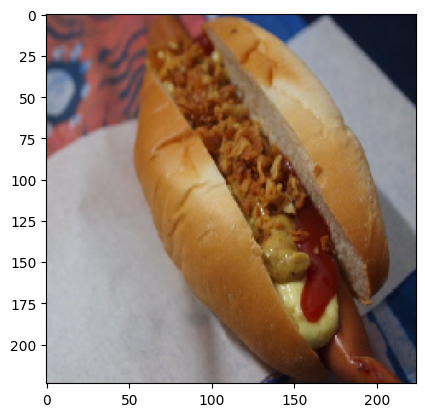

In [4]:
plt.imshow(img)

In [5]:
probas = model.predict(img_array.reshape(1, 224,224,3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [6]:
decode_predictions(probas)

[[('n02782093', 'balloon', 0.42284554),
  ('n09256479', 'coral_reef', 0.105973125),
  ('n02606052', 'rock_beauty', 0.08158754),
  ('n04209239', 'shower_curtain', 0.08039982),
  ('n03530642', 'honeycomb', 0.04067585)]]

#### Load as a json file (if no access to internet)

In [7]:
#import json
#with open("json file path") as f:
#    imagenet = json.load(f)
# probas

## Transfer learning

- Bring back `MobileNet` and do not include the top layer on the network (the last layer excluded).

In [8]:
base_model = MobileNet()

#### Take the output of the last but one layer, and use it to build on top of it.

In [9]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, Sequential

In [10]:
len(base_model.layers)

91

In [11]:
new_model = Sequential([base_model.layers[i] for i in range(91)])
new_model.trainable = False  # True = We do fine-tuning, False = Feature extraction + fine-tuning comes later
new_model.add(Dense(512, activation='relu'))
new_model.add(Dense(256, activation='relu'))
new_model.add(Dense(2, activation='softmax')) # Use softmax activation on the last layer to get scores summing to 1

In [12]:
#new_new_model = Sequential(base_model.layers[::-1]+[Dense(512, activation='relu'), Dense(2, activation='softmax')])

#### Use generator to bring in the training images for hotdog/not hotdog 

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input
                                   , horizontal_flip=True, vertical_flip=True)

In [15]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input
                                   , horizontal_flip=True, vertical_flip=True)

In [16]:
train_generator = train_datagen.flow_from_directory('./data/hotdog/train/', 
                                                    target_size=(224,224), 
                                                    color_mode='rgb', 
                                                    class_mode='categorical', 
                                                    batch_size=16)

Found 498 images belonging to 2 classes.


In [17]:
test_generator = test_datagen.flow_from_directory('./data/hotdog/test/', 
                                                    target_size=(224,224), 
                                                    color_mode='rgb', 
                                                    class_mode='categorical', 
                                                    batch_size=16)

Found 500 images belonging to 2 classes.


In [18]:
new_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
history = new_model.fit(train_generator,
                                  epochs=20, #usually 100 / 200 epochs
                                  validation_data=test_generator
                                 )

Epoch 1/20


C:\Users\HP\Desktop\intro-ml-ai\env\lib\site-packages\keras\src\backend\tensorflow\trainer.py:74: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
C:\Users\HP\Desktop\intro-ml-ai\env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.5858 - loss: 0.6823 - val_accuracy: 0.6060 - val_loss: 0.6805
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 939ms/step - accuracy: 0.5802 - loss: 0.6810 - val_accuracy: 0.6120 - val_loss: 0.6809
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 835ms/step - accuracy: 0.6359 - loss: 0.6800 - val_accuracy: 0.6160 - val_loss: 0.6800
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 835ms/step - accuracy: 0.5874 - loss: 0.6820 - val_accuracy: 0.6180 - val_loss: 0.6801
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 812ms/step - accuracy: 0.6160 - loss: 0.6804 - val_accuracy: 0.6400 - val_loss: 0.6802
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 759ms/step - accuracy: 0.5712 - loss: 0.6836 - val_accuracy: 0.6180 - val_loss: 0.6806
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 850ms/step - accuracy: 0.6021 - loss: 0.6826 - val_accuracy: 0.6100 - val_loss: 0.6812
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 901ms/step - accuracy: 0.5860 - loss: 0.6820 - val_accuracy: 0.5960 -

In [20]:
def load_img(file):
    img = image.load_img(file, target_size=(224,224))
    img_array = image.img_to_array(img) # Converting from PIL object into a numpy array
    return img_array.reshape(1, 224,224,3)

In [21]:
preds_to_labels = { train_generator.class_indices[k]:k for k in train_generator.class_indices.keys()}

In [22]:
counter = {'hot_dog':0, 'not_hot_dog':0}
import glob
for file in glob.glob('./data/hotdog/test/hot_dog/*'):
    preds = new_model.predict(load_img(file))
    pred = np.argmax(preds)
    counter[preds_to_labels[pred]] += 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━

In [23]:
counter

{'hot_dog': 241, 'not_hot_dog': 9}

## Model persistance

In [24]:
import tensorflow as tf

In [25]:
tf.saved_model.save(new_model, "./tmp/mobilenet/1/")

INFO:tensorflow:Assets written to: ./tmp/mobilenet/1/assets


INFO:tensorflow:Assets written to: ./tmp/mobilenet/1/assets
